In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict
from pymatgen.ext.matproj import MPRester

from pymatgen.core import Structure
from IPython.display import Image

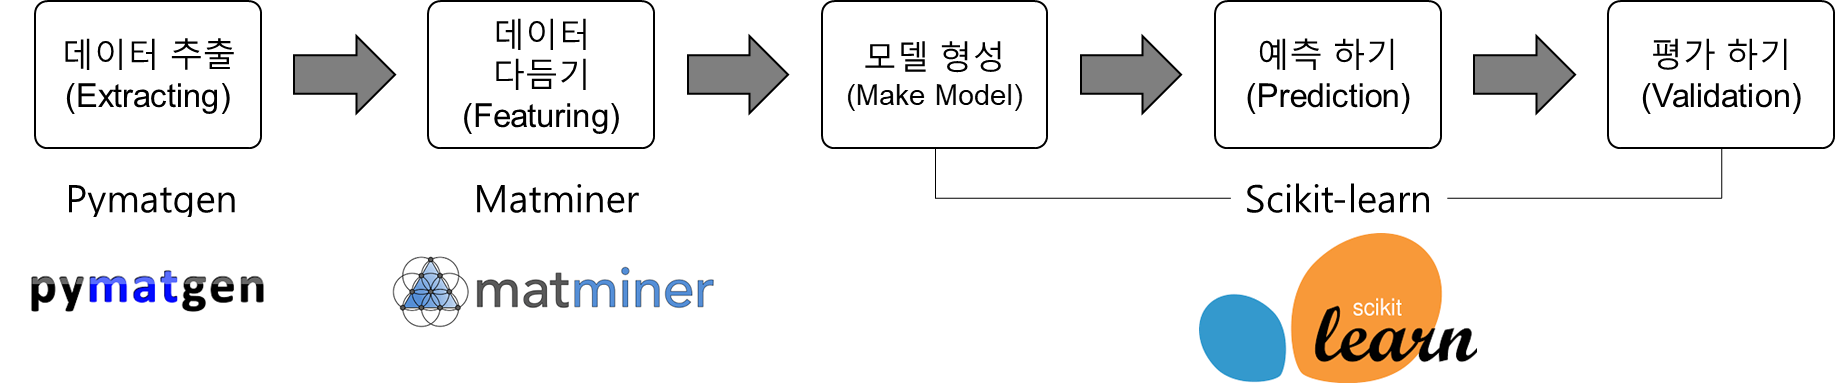

In [2]:
Image('image/matminer1.PNG')

# 1. 데이터 추출 (Extracting) 


## Query를 이용한 데이터 추출 (Extracting data through query in Pymatgen)
Materials Project에서는 Query를 이용해 데이터를 추출할 수 있다. query는 pymatgen.ext.matproj 모듈에서 제공해주며 총 25개의 데이터를 가져올 수가 있다. query 말고 entry나 materials id를 이용해 band structure, phase diagram 등 다양한 데이터를 가지고 올 수 있다. <br>
(Materials Project can extract data using Query. The query is provided by the pymatgen.ext.matproj module, and a total of 25 data can be imported. You can bring various data such as band structure and phase diagram by using entry or materials id other than query.)<br>


criteria는 pymatgen.ext.matproj.MPRester.query에 사용할 기준을 넣어준다. Materials Project 데이터는 MongoDB로 구성되어있기 때문에, 다양한 query를 이용하려면 MongDB를 다루는 방법을 공부하는 게 좋다. <br>
(criteria puts in pymatgen.ext.matproj.MPRester.query. Since the Materials Project data is composed of MongoDB, it is better to study how to handle MongDB to use various queries.)<br>

* 논리연산자


|operator|descriptor|
|:-----------:|:-----------:|
|$$eq |(equals) 주어진 값과 일치하는 값|
|$gt |(greater than) 주어진 값보다 큰 값|
|$gte |(greather than or equals) 주어진 값보다 크거나 같은 값|
|$lt|(less than) 주어진 값보다 작은 값|
|$lte|(less than or equals) 주어진 값보다 작거나 같은 값|
|$ne|(not equal) 주어진 값과 일치하지 않는 값|
|$in|주어진 배열 안에 속하는 값|
|$nin|주어빈 배열 안에 속하지 않는 값|

## API key 가져오기



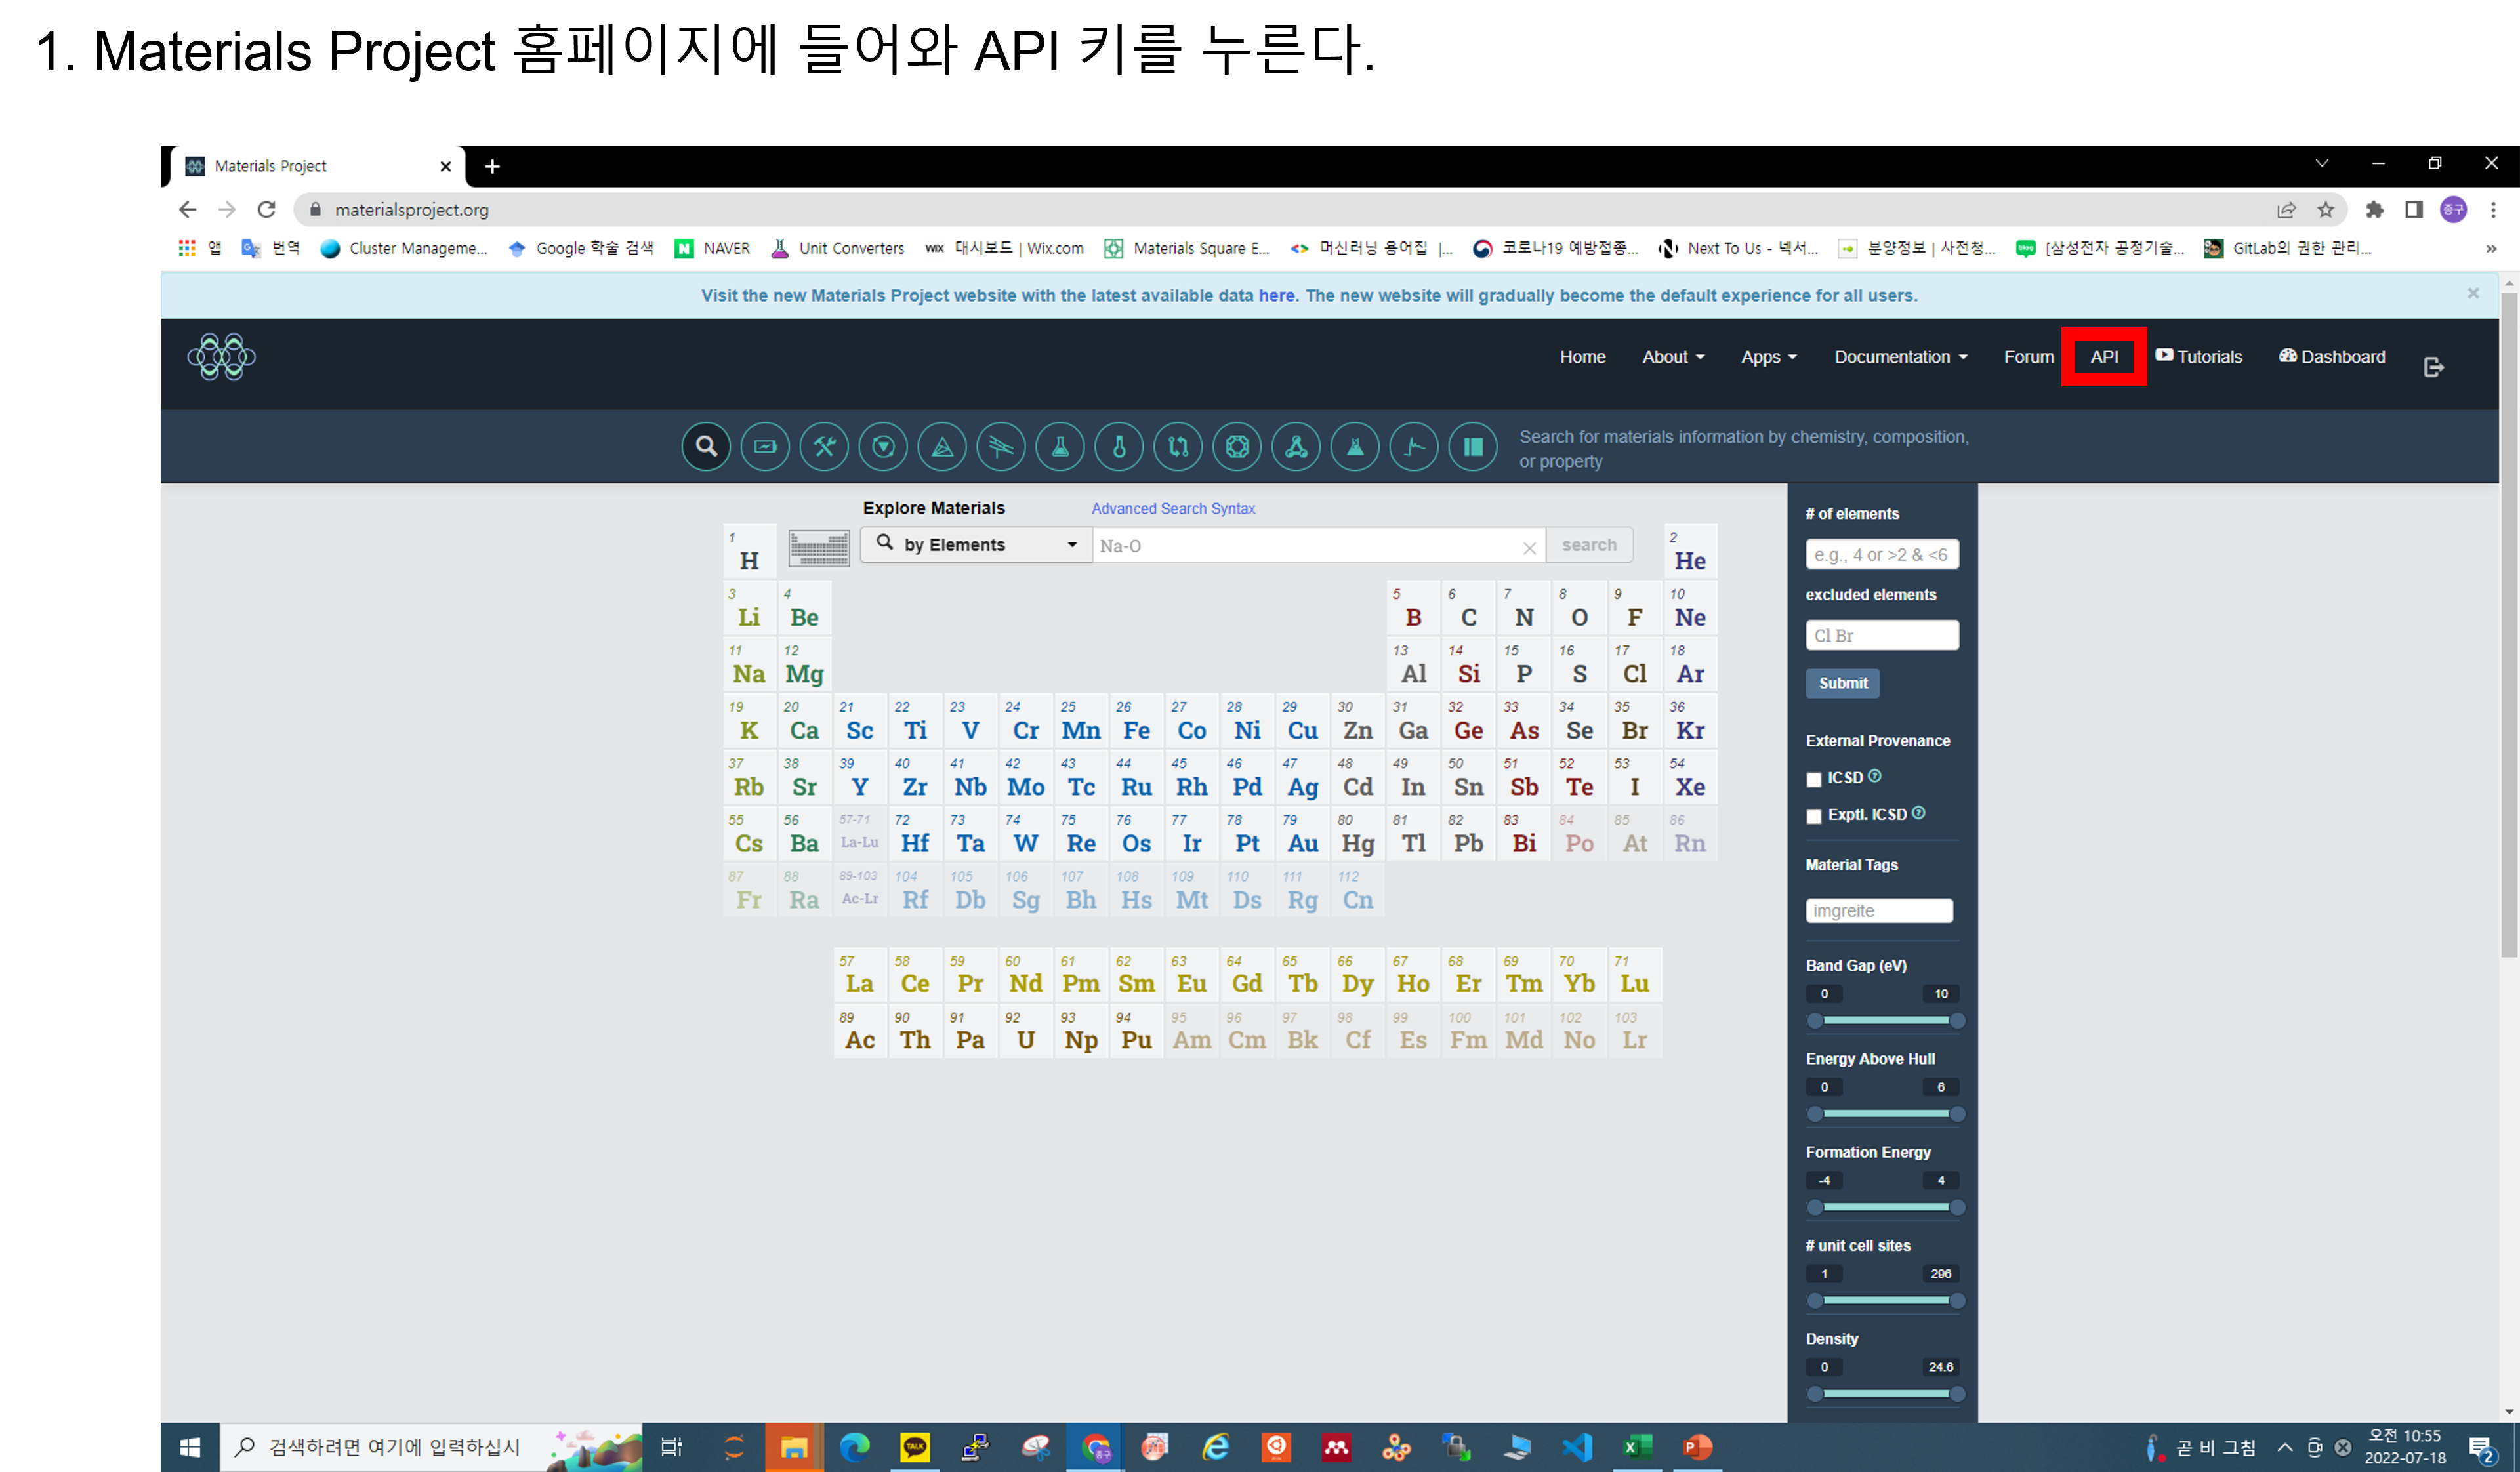

In [3]:
Image("image/matminer2.png")

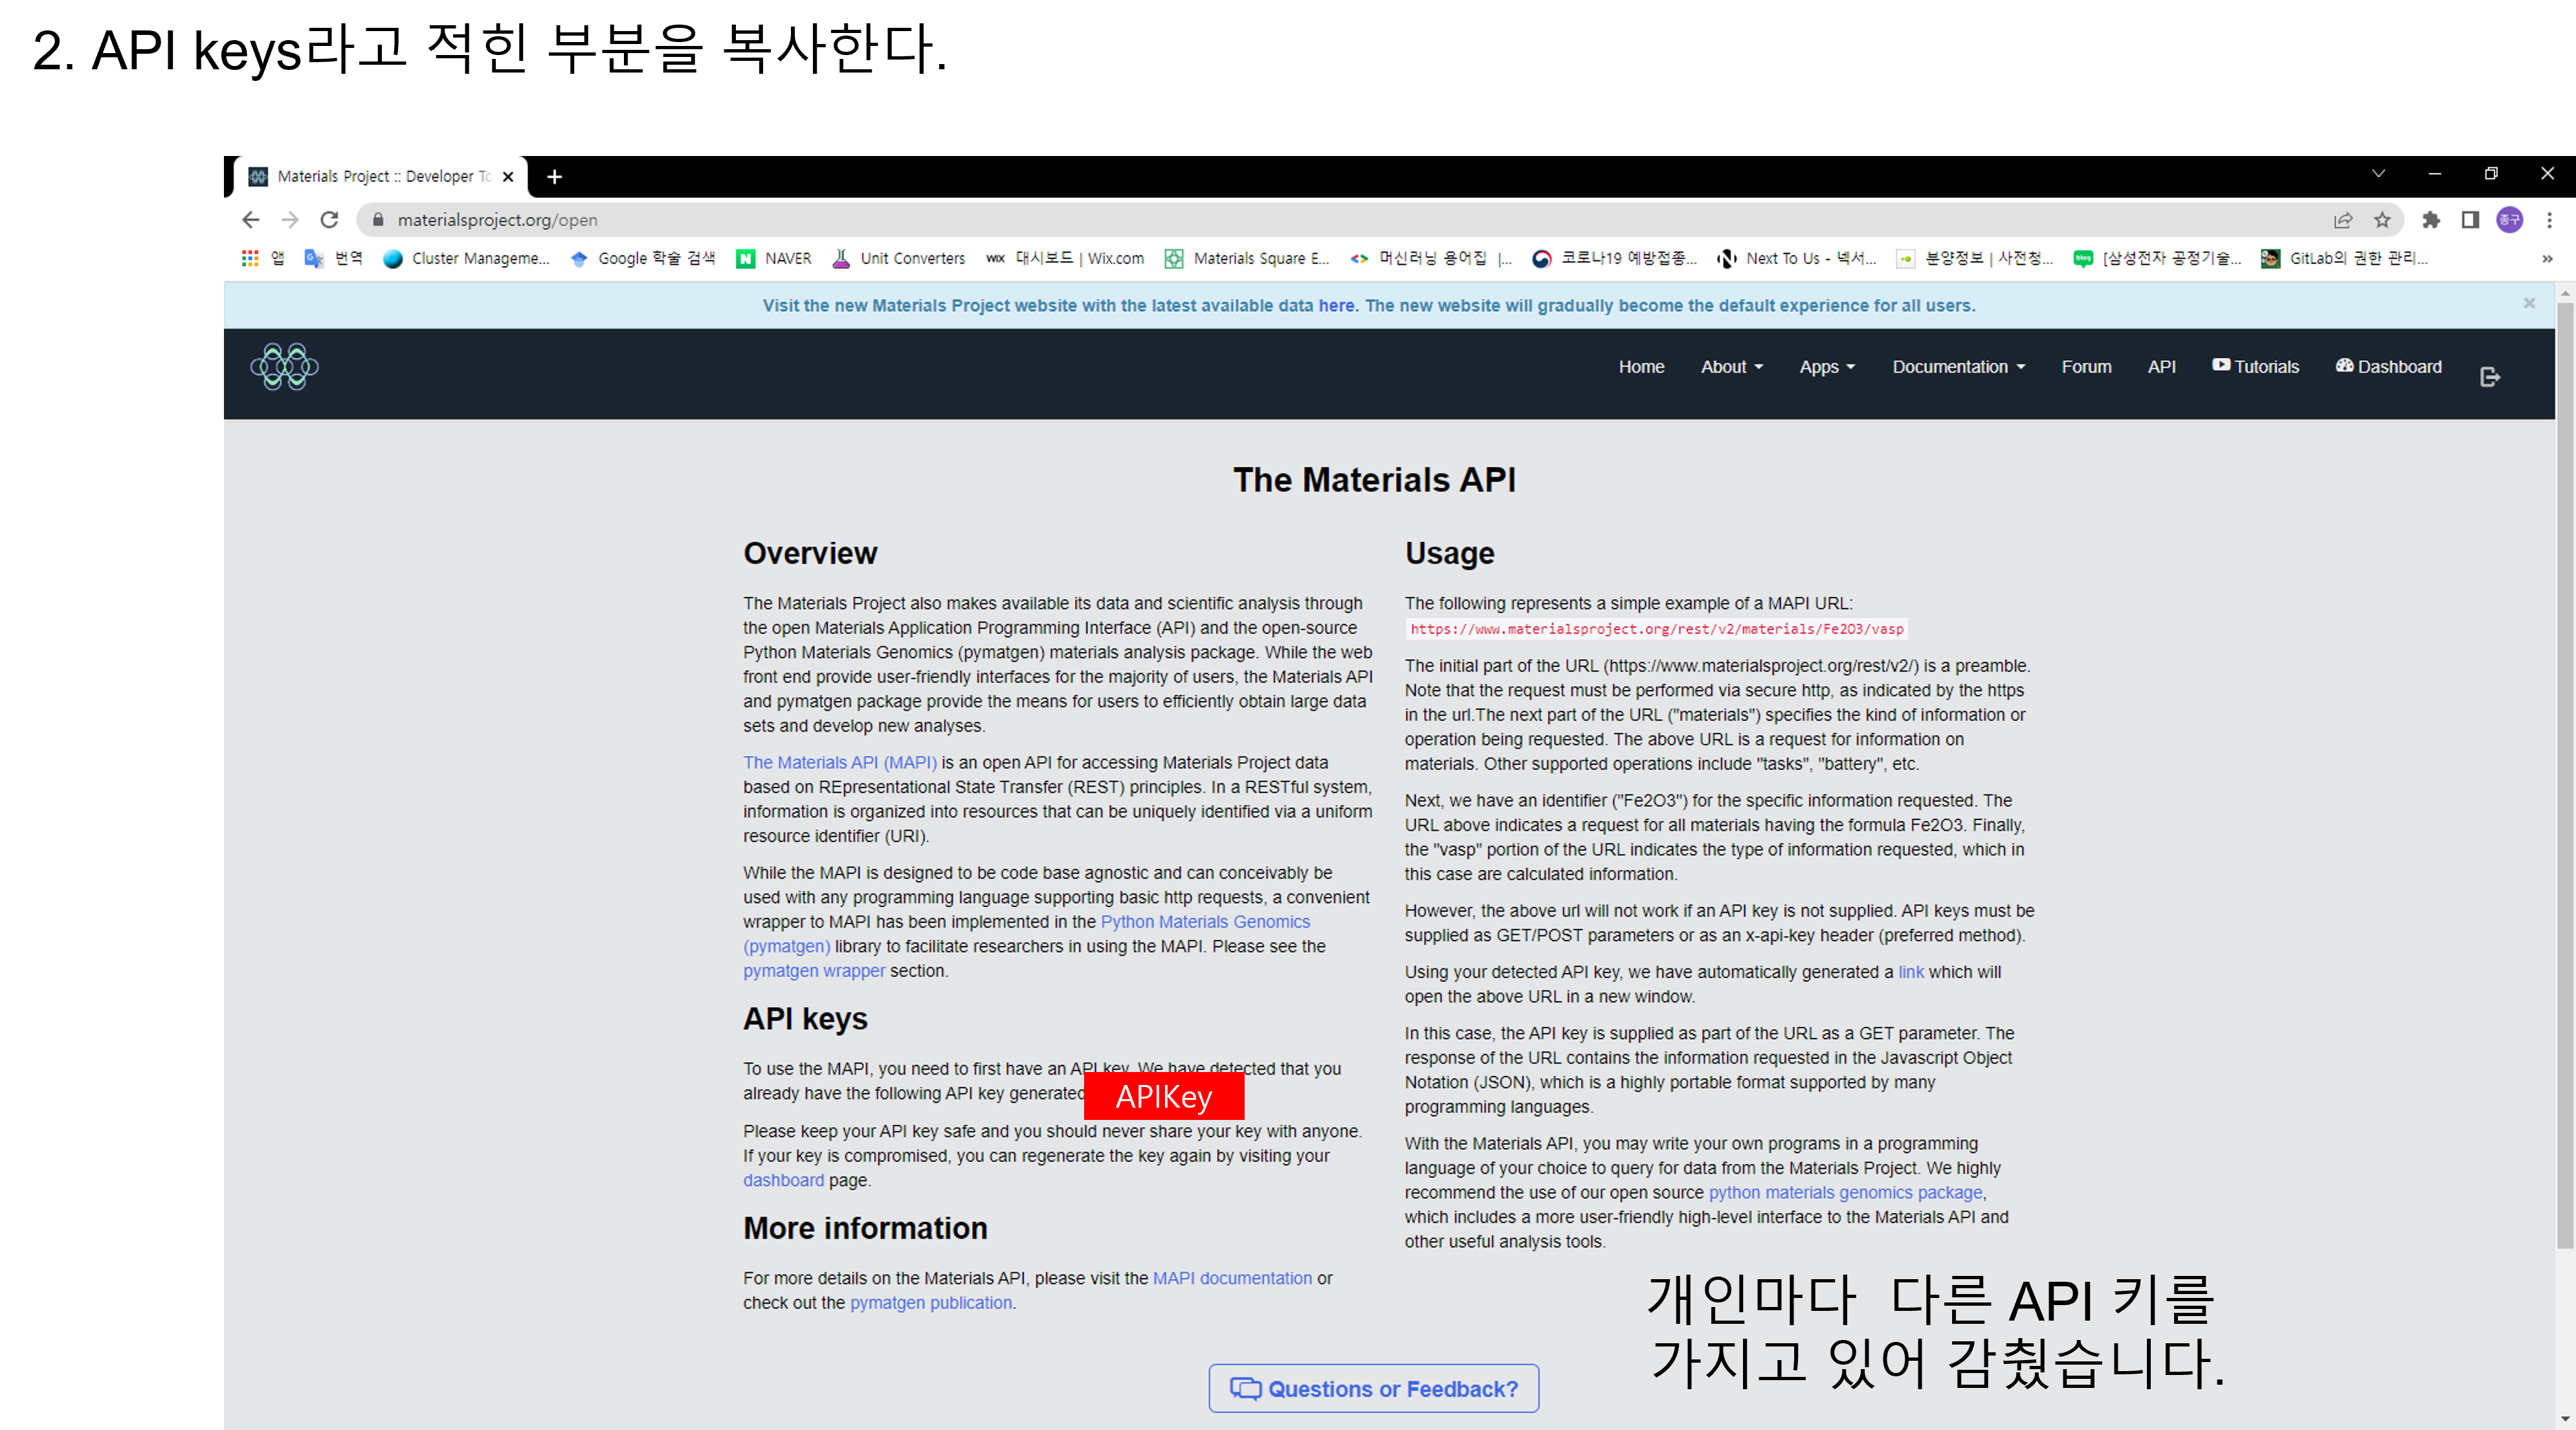

In [4]:
Image("image/matminer3.png")

In [35]:
mpr = MPRester("ENTER_API_KEY")
properties =  ['material_id','pretty_formula','energy_per_atom',"formation_energy_per_atom","energy",'e_above_hull','density','volume','cif','icsd_ids','elasticity']
criteria = {"nelements":{"$gte":2}}
data = mpr.query(criteria, properties)

D:\anaconda3\lib\site-packages\pymatgen\ext\matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████| 125619/125619 [02:36<00:00, 801.85it/s]


# 데이터 다듬기 (1) - Featuring (1)

125,619개 중 약 12,800개 데이터만이 bulk modulus 값을 제공해준다. 따라서, bulk modulus를 제공해주는 값만 데이터로 생성시켜준다.
이 후, bulk modulus를 예측하는 데 있어 필요한 feature를 lattice constant, electron 개수, 원자량을 feature로 추가해준다.<br>
(Aproximately 12,800 data out of 125,619 provide bulk modulus values. Therefore, only values that provide bulk modulus are extracted as target and features data. After that, lattice constant, number of electrons, and atomic weight are added as features necessary for predicting bulk modulus.)

In [49]:
dataframe = defaultdict(list)

for d in tqdm(data) :
    if d['elasticity'] != None and np.log10(d['elasticity']['K_VRH']) > 0 :
        for k,v in d.items() :
            if k == 'elasticity' :
                dataframe['K_VRH'].append(v['K_VRH'])
                dataframe['log_KVRH'].append(np.log10(v['K_VRH']))
            elif k == 'cif' : 
                structure = Structure.from_str(v,fmt='cif')
                dataframe['structure'].append(structure)
                dataframe['lattice_const_a'].append(structure.lattice.a)
                dataframe['lattice_const_b'].append(structure.lattice.b)
                dataframe['lattice_const_c'].append(structure.lattice.c)
                dataframe['total_electrons'].append(structure.composition.total_electrons)
                dataframe['total_weight'].append(structure.composition.weight)                
            else :
                dataframe[k].append(v)

  0%|                                                                                       | 0/125619 [00:00<?, ?it/s]D:\anaconda3\lib\site-packages\pymatgen\io\cif.py:1165: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
  2%|█▋                                                                        | 2815/125619 [00:01<01:06, 1840.09it/s]C:\Users\sora_\AppData\Local\Temp\ipykernel_17628\2147121077.py:4: RuntimeWarning: divide by zero encountered in log10
  if d['elasticity'] != None and np.log10(d['elasticity']['K_VRH']) > 0 :
100%|████████████████████████████████████████████████████████████████████████| 125619/125619 [00:31<00:00, 3937.69it/s]


In [50]:
df = pd.DataFrame(dataframe).set_index("material_id")
df.head()

pretty_formula  energy_per_atom  formation_energy_per_atom  \
material_id                                                              
mp-1002206             SiC        -6.787957                   0.537123   
mp-11279              TiBe        -5.957301                  -0.140069   
mp-11714               SiC        -7.530537                  -0.205457   
mp-1490              AlAu4        -3.579163                  -0.210942   
mp-1934               LiZn        -1.803008                  -0.218816   

                energy  e_above_hull    density      volume  \
material_id                                                   
mp-1002206  -13.575914      0.742811   4.008509   16.609992   
mp-11279    -11.914603      0.005377   3.752194   25.171970   
mp-11714    -60.244294      0.000231   3.171930   83.963159   
mp-1490     -71.583257      0.000000  15.415555  351.096432   
mp-1934      -7.212031      0.000000   4.082778   58.852085   

                                                     structure  \
material_id                                                      
mp-1002206   [[0. 0. 0.] Si, [1.65348723 1.16919203 2.86392...   
mp-11279     [[1.4653535 1.4653535 1.4653535] Ti, [0. 0. 0....   
mp-11714     [[1.54700303 0.89316262 9.49836211] Si, [-1.18...   
mp-1490      [[0.44731419 0.44731419 0.44731419] Al, [3.080...   
mp-1934      [[1.26038046 0.89122357 2.18304299] Li, [0. 0....   

             lattice_const_a  lattice_const_b  lattice_const_c  \
material_id                                                      
mp-1002206          2.863924         2.863924         2.863924   
mp-11279            2.930707         2.930707         2.930707   
mp-11714            3.094006         3.094006        10.127816   
mp-1490             7.054650         7.054650         7.054650   
mp-1934             4.366086         4.366086         4.366086   

             total_electrons  total_weight  \
material_id                                  
mp-1002206              20.0     40.096200   
mp-11279                26.0     56.879182   
mp-11714                80.0    160.384800   
mp-1490               1316.0   3259.391258   
mp-1934                 66.0    144.700000   

                                            icsd_ids  K_VRH  log_KVRH  
material_id                                                            
mp-1002206                                  [182362]  241.0  2.382017  
mp-11279                             [616457, 58743]  126.0  2.100371  
mp-11714                                    [164971]  214.0  2.330414  
mp-1490      [655053, 104616, 606018, 606030, 57498]  127.0  2.103804  
mp-1934             [642409, 642412, 104791, 104792]   42.0  1.623249

# 데이터 다듬기 (2) - Featuring (2)

materials project에서 제공해주는 데이터는 bulk modulus를 예측하는 데 있어 한계가 있다. 본 한계를 극복하기 위해서 Matminer에서 제공해주는 모듈을 활용할 것이다. 본 모듈은 formula와 구조를 통해서 featuring을 늘려주는 기능이다.<br>
(The data provided by the materials project has limitations in predicting the bulk modulus. To overcome this limitation, we will use the module provided by Matminer. This module is a function that increases featuring through formulas and structures.)

본 기능은 시간이 오래 걸리므로 data.csv로 저장해놓았습니다. (This function takes a long time, so I saved it as data.csv.)

In [51]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import DensityFeatures

dataframe1 = StrToComposition().featurize_dataframe(df, "pretty_formula")
ep_feat = ElementProperty.from_preset(preset_name="magpie")

dataframe1 = ep_feat.featurize_dataframe(dataframe1, col_id="composition")
df_feat = DensityFeatures(desired_features='vpa')
dataframe1 = df_feat.featurize_dataframe(dataframe1, "structure")

StrToComposition:   0%|          | 0/12818 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/12818 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/12818 [00:00<?, ?it/s]

In [ ]:
dataframe1.drop_to_csv('data.csv')